# 🌼 꽃 분류 딥러닝 실습 (이진 분류)

**데이지(Daisy) vs 민들레(Dandelion) 이미지 분류 모델**

## 📝 프로젝트 개요
이 노트북은 딥러닝을 활용하여 꽃 이미지를 자동으로 분류하는 이진 분류 모델을 구현합니다.

### 🎯 학습 목표
1. **이미지 데이터 전처리**: 원본 이미지를 신경망 학습에 적합한 형태로 변환
2. **신경망 모델 설계**: 이진 분류를 위한 효과적인 모델 구조 구성
3. **모델 훈련 및 최적화**: 훈련 과정 모니터링 및 성능 개선
4. **결과 분석 및 검증**: 모델 성능 평가 및 시각화

### 📊 데이터셋 정보
- **클래스**: 2개 (데이지=0, 민들레=1)
- **이미지 크기**: 80x80 픽셀로 통일
- **데이터 분할**: Train/Test 분리
- **데이터 형식**: RGB 컬러 이미지

### 🏗️ 모델 아키텍처
- **유형**: Dense(완전연결) 신경망
- **입력**: 19,200개 특성 (80×80×3)
- **출력**: 1개 노드 (Sigmoid 활성화)
- **손실함수**: Binary Crossentropy


## 1. 📚 환경 설정 및 라이브러리 Import

필요한 라이브러리들을 import하고 기본 설정을 진행합니다.


In [43]:
# === 기본 라이브러리 ===
import numpy as np
import os
import random
from pathlib import Path

# === 이미지 처리 ===
import PIL.Image as pilimg
import imghdr

# === 데이터 처리 ===
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === 딥러닝 프레임워크 ===
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks

# === 시각화 ===
import matplotlib.pyplot as plt
import seaborn as sns

# === 설정 ===
# 랜덤 시드 고정 (재현 가능한 결과를 위해)
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# 경고 메시지 줄이기
import warnings
warnings.filterwarnings('ignore')

# matplotlib 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("✅ 라이브러리 import 및 환경 설정 완료!")
print(f"🔧 TensorFlow 버전: {tf.__version__}")
print(f"🔧 Numpy 버전: {np.__version__}")

# GPU 사용 가능 여부 확인
if tf.config.list_physical_devices('GPU'):
    print("🚀 GPU 사용 가능!")
else:
    print("💻 CPU 모드로 실행")


✅ 라이브러리 import 및 환경 설정 완료!
🔧 TensorFlow 버전: 2.19.0
🔧 Numpy 버전: 2.1.3
💻 CPU 모드로 실행


## 2. ⚙️ 설정 및 경로 정의

프로젝트에서 사용할 경로와 하이퍼파라미터를 정의합니다.


In [44]:
# === 경로 설정 ===
# 현재 작업 디렉토리 기준으로 상대 경로 사용
BASE_DIR = Path(r"C:/Users/ryan9/문서/GitHub/SeSac-AI-Developer-Notes-2025")
DATA_DIR = BASE_DIR / "07_Deep_Learning" / "data"
FLOWERS_DIR = DATA_DIR / "flowers"
NPZ_DIR = DATA_DIR / "npz"

# NPZ 저장 디렉토리 생성
NPZ_DIR.mkdir(parents=True, exist_ok=True)

# === 하이퍼파라미터 설정 ===
CONFIG = {
    # 데이터 설정
    'IMAGE_SIZE': (80, 80),           # 이미지 크기
    'CHANNELS': 3,                    # RGB 채널
    'FLOWER_CLASSES': {              # 꽃 클래스 정의
        'daisy': 0,
        'dandelion': 1
    },
    
    # 모델 하이퍼파라미터
    'BATCH_SIZE': 100,               # 배치 크기
    'EPOCHS': 100,                   # 훈련 에포크
    'LEARNING_RATE': 0.001,          # 학습률
    'VALIDATION_SPLIT': 0.2,         # 검증 데이터 비율
    
    # 모델 구조
    'HIDDEN_LAYERS': [128, 64, 64, 32],  # 은닉층 구조
    'DROPOUT_RATE': 0.5,             # 드롭아웃 비율
    'ACTIVATION': 'relu',            # 활성화 함수
}

print("📁 경로 설정:")
print(f"   - 데이터 디렉토리: {DATA_DIR}")
print(f"   - 꽃 이미지 디렉토리: {FLOWERS_DIR}")
print(f"   - NPZ 저장 디렉토리: {NPZ_DIR}")

print("\n⚙️ 하이퍼파라미터:")
for key, value in CONFIG.items():
    print(f"   - {key}: {value}")


📁 경로 설정:
   - 데이터 디렉토리: C:\Users\ryan9\문서\GitHub\SeSac-AI-Developer-Notes-2025\07_Deep_Learning\data
   - 꽃 이미지 디렉토리: C:\Users\ryan9\문서\GitHub\SeSac-AI-Developer-Notes-2025\07_Deep_Learning\data\flowers
   - NPZ 저장 디렉토리: C:\Users\ryan9\문서\GitHub\SeSac-AI-Developer-Notes-2025\07_Deep_Learning\data\npz

⚙️ 하이퍼파라미터:
   - IMAGE_SIZE: (80, 80)
   - CHANNELS: 3
   - FLOWER_CLASSES: {'daisy': 0, 'dandelion': 1}
   - BATCH_SIZE: 100
   - EPOCHS: 100
   - LEARNING_RATE: 0.001
   - VALIDATION_SPLIT: 0.2
   - HIDDEN_LAYERS: [128, 64, 64, 32]
   - DROPOUT_RATE: 0.5
   - ACTIVATION: relu


## 3. 🔄 데이터 처리 함수들

이미지 데이터를 처리하고 신경망 학습에 적합한 형태로 변환하는 함수들을 정의합니다.


In [45]:
def validate_image(image_path):
    """
    이미지 파일의 유효성을 검증하는 함수
    
    Args:
        image_path (Path): 이미지 파일 경로
        
    Returns:
        bool: 유효한 이미지 파일이면 True, 아니면 False
    """
    try:
        # 이미지 형식 확인
        kind = imghdr.what(str(image_path))
        if kind not in ["gif", "png", "jpeg", "jpg"]:
            return False
            
        # 이미지 열기 시도
        with pilimg.open(image_path) as img:
            # RGB 모드로 변환 가능한지 확인
            img.convert('RGB')
            return True
    except Exception:
        return False

def process_single_image(image_path, target_size=None):
    """
    단일 이미지를 처리하는 함수
    
    Args:
        image_path (Path): 이미지 파일 경로
        target_size (tuple): 목표 이미지 크기, 기본값은 CONFIG에서 가져옴
        
    Returns:
        numpy.ndarray: 처리된 이미지 배열 또는 None (실패시)
    """
    if target_size is None:
        target_size = CONFIG['IMAGE_SIZE']
        
    try:
        with pilimg.open(image_path) as img:
            # RGB 모드로 변환
            img = img.convert('RGB')
            # 크기 조정
            img_resized = img.resize(target_size)
            # numpy 배열로 변환
            pixel_array = np.array(img_resized)
            
            # 예상된 shape 확인 (height, width, channels)
            expected_shape = target_size + (CONFIG['CHANNELS'],)
            if pixel_array.shape == expected_shape:
                return pixel_array
            else:
                return None
                
    except Exception as e:
        print(f"이미지 처리 실패 - {image_path.name}: {e}")
        return None

def create_dataset(flower_name, label, is_train=True):
    """
    특정 꽃 종류의 데이터셋을 생성하는 함수
    
    Args:
        flower_name (str): 꽃 이름 ('daisy' 또는 'dandelion')
        label (int): 클래스 라벨 (0 또는 1)
        is_train (bool): 훈련용 데이터 여부
        
    Returns:
        tuple: (이미지 데이터 리스트, 라벨 리스트)
    """
    # 데이터 경로 설정 (올바른 구조: flowers/train/daisy)
    data_type = "train" if is_train else "test"  # test 폴더 사용
    image_dir = FLOWERS_DIR / data_type / flower_name
    
    if not image_dir.exists():
        print(f"⚠️ 경로를 찾을 수 없습니다: {image_dir}")
        return [], []
    
    data = []
    labels = []
    processed_count = 0
    error_count = 0
    
    # 이미지 파일 목록 가져오기
    image_files = list(image_dir.glob("*"))
    total_files = len(image_files)
    
    print(f"📂 {flower_name} {data_type} 데이터 처리 시작... (총 {total_files}개 파일)")
    
    for i, image_path in enumerate(image_files, 1):
        # 진행 상황 출력
        if i % 100 == 0 or i == total_files:
            print(f"   진행률: {i}/{total_files} ({i/total_files*100:.1f}%)")
            
        # 이미지 유효성 검증
        if not validate_image(image_path):
            error_count += 1
            continue
            
        # 이미지 처리
        processed_image = process_single_image(image_path)
        if processed_image is not None:
            data.append(processed_image)
            labels.append(label)
            processed_count += 1
        else:
            error_count += 1
    
    print(f"✅ {flower_name} {data_type} 처리 완료:")
    print(f"   - 성공: {processed_count}개")
    print(f"   - 실패: {error_count}개")
    
    return data, labels

def save_processed_data(data, labels, flower_label, is_train=True):
    """
    처리된 데이터를 NPZ 파일로 저장하는 함수
    
    Args:
        data (list): 이미지 데이터 리스트
        labels (list): 라벨 리스트
        flower_label (int): 꽃 클래스 라벨
        is_train (bool): 훈련용 데이터 여부
    """
    data_type = "train" if is_train else "test"
    filename = f"imagedata{flower_label}_{data_type}.npz"
    filepath = NPZ_DIR / filename
    
    # numpy 배열로 변환
    data_array = np.array(data)
    labels_array = np.array(labels)
    
    # NPZ 파일로 저장
    np.savez_compressed(str(filepath), data=data_array, targets=labels_array)
    
    print(f"💾 데이터 저장 완료: {filepath}")
    print(f"   - Shape: {data_array.shape}")
    print(f"   - 라벨 분포: {np.bincount(labels_array)}")

def initialize_all_data():
    """
    모든 꽃 데이터를 처리하고 저장하는 함수
    """
    print("🚀 전체 데이터 초기화 시작...\n")
    
    flower_classes = CONFIG['FLOWER_CLASSES']
    
    for flower_name, label in flower_classes.items():
        print(f"🌸 {flower_name} (라벨: {label}) 처리 중...")
        
        # 훈련 데이터 처리
        train_data, train_labels = create_dataset(flower_name, label, is_train=True)
        if train_data:
            save_processed_data(train_data, train_labels, label, is_train=True)
        
        # 테스트 데이터 처리
        test_data, test_labels = create_dataset(flower_name, label, is_train=False)
        if test_data:
            save_processed_data(test_data, test_labels, label, is_train=False)
        
        print()  # 빈 줄 추가
    
    print("🎉 모든 데이터 초기화 완료!")


### 3.1 데이터 로드 및 전처리 함수


In [46]:
def load_processed_data():
    """
    저장된 NPZ 파일에서 데이터를 로드하는 함수
    
    Returns:
        tuple: (X_train, y_train, X_test, y_test) 훈련 및 테스트 데이터
        
    Raises:
        FileNotFoundError: NPZ 파일이 없는 경우
    """
    print("📖 저장된 데이터 로드 중...")
    
    try:
        # 훈련 데이터 로드
        train_files = {
            0: NPZ_DIR / "imagedata0_train.npz",  # daisy
            1: NPZ_DIR / "imagedata1_train.npz"   # dandelion
        }
        
        # 테스트 데이터 로드
        test_files = {
            0: NPZ_DIR / "imagedata0_test.npz",   # daisy
            1: NPZ_DIR / "imagedata1_test.npz"    # dandelion
        }
        
        # 파일 존재 확인
        all_files = list(train_files.values()) + list(test_files.values())
        for file_path in all_files:
            if not file_path.exists():
                raise FileNotFoundError(f"NPZ 파일을 찾을 수 없습니다: {file_path}")
        
        # 훈련 데이터 결합
        train_data_list = []
        train_labels_list = []
        
        for label, file_path in train_files.items():
            npz_file = np.load(str(file_path))
            train_data_list.append(npz_file["data"])
            train_labels_list.append(npz_file["targets"])
            
        X_train = np.concatenate(train_data_list, axis=0)
        y_train = np.concatenate(train_labels_list, axis=0)
        
        # 테스트 데이터 결합
        test_data_list = []
        test_labels_list = []
        
        for label, file_path in test_files.items():
            npz_file = np.load(str(file_path))
            test_data_list.append(npz_file["data"])
            test_labels_list.append(npz_file["targets"])
            
        X_test = np.concatenate(test_data_list, axis=0)
        y_test = np.concatenate(test_labels_list, axis=0)
        
        print("✅ 데이터 로드 완료!")
        print(f"📊 데이터 정보:")
        print(f"   - 훈련 데이터: {X_train.shape}")
        print(f"   - 테스트 데이터: {X_test.shape}")
        print(f"   - 훈련 라벨 분포: {np.bincount(y_train)}")
        print(f"   - 테스트 라벨 분포: {np.bincount(y_test)}")
        
        return X_train, y_train, X_test, y_test
        
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        print("💡 먼저 initialize_all_data() 함수를 실행하여 데이터를 생성해주세요.")
        raise

def preprocess_data(X_train, X_test):
    """
    로드된 데이터를 신경망 학습에 적합하게 전처리하는 함수
    
    Args:
        X_train (numpy.ndarray): 훈련 이미지 데이터
        X_test (numpy.ndarray): 테스트 이미지 데이터
        
    Returns:
        tuple: (X_train_processed, X_test_processed) 전처리된 데이터
    """
    print("🔄 데이터 전처리 시작...")
    
    print(f"전처리 전 데이터 형태:")
    print(f"   - X_train: {X_train.shape}")
    print(f"   - X_test: {X_test.shape}")
    
    # 1. 차원 변환: (samples, height, width, channels) -> (samples, features)
    n_features = CONFIG['IMAGE_SIZE'][0] * CONFIG['IMAGE_SIZE'][1] * CONFIG['CHANNELS']
    X_train_flattened = X_train.reshape(X_train.shape[0], n_features)
    X_test_flattened = X_test.reshape(X_test.shape[0], n_features)
    
    print(f"차원 변환 후:")
    print(f"   - X_train: {X_train_flattened.shape}")
    print(f"   - X_test: {X_test_flattened.shape}")
    
    # 2. 정규화: 픽셀 값을 0-1 범위로 스케일링
    X_train_normalized = X_train_flattened.astype('float32') / 255.0
    X_test_normalized = X_test_flattened.astype('float32') / 255.0
    
    # 3. 표준화 (선택사항 - 이미 정규화했으므로 주석 처리)
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train_normalized)
    # X_test_scaled = scaler.transform(X_test_normalized)
    
    print("✅ 데이터 전처리 완료!")
    print(f"   - 픽셀 값 범위: [{X_train_normalized.min():.3f}, {X_train_normalized.max():.3f}]")
    
    return X_train_normalized, X_test_normalized

def shuffle_data(X, y, random_state=42):
    """
    데이터를 섞는 함수
    
    Args:
        X (numpy.ndarray): 특성 데이터
        y (numpy.ndarray): 라벨 데이터
        random_state (int): 랜덤 시드
        
    Returns:
        tuple: (X_shuffled, y_shuffled) 섞인 데이터
    """
    np.random.seed(random_state)
    indices = np.random.permutation(len(X))
    return X[indices], y[indices]


## 4. 🧠 신경망 모델 정의

이진 분류를 위한 Dense 신경망 모델을 정의합니다.


In [47]:
def create_binary_classification_model(input_shape=None, add_dropout=True):
    """
    이진 분류를 위한 신경망 모델을 생성하는 함수
    
    Args:
        input_shape (int): 입력 특성의 개수 (None이면 CONFIG에서 계산)
        add_dropout (bool): 드롭아웃 레이어 추가 여부
        
    Returns:
        tf.keras.Model: 컴파일된 신경망 모델
    """
    if input_shape is None:
        input_shape = CONFIG['IMAGE_SIZE'][0] * CONFIG['IMAGE_SIZE'][1] * CONFIG['CHANNELS']
    
    print(f"🏗️ 신경망 모델 생성 중... (입력 크기: {input_shape})")
    
    # Sequential 모델 생성
    model = models.Sequential(name="FlowerClassifier")
    
    # 입력층 및 은닉층 추가
    hidden_layers = CONFIG['HIDDEN_LAYERS']
    activation = CONFIG['ACTIVATION']
    
    for i, units in enumerate(hidden_layers):
        if i == 0:
            # 첫 번째 층에만 input_shape 지정
            model.add(layers.Dense(
                units, 
                activation=activation,
                input_shape=(input_shape,),
                name=f"dense_layer_{i+1}"
            ))
        else:
            model.add(layers.Dense(
                units, 
                activation=activation,
                name=f"dense_layer_{i+1}"
            ))
        
        # 드롭아웃 추가 (과적합 방지)
        if add_dropout:
            model.add(layers.Dropout(
                CONFIG['DROPOUT_RATE'], 
                name=f"dropout_{i+1}"
            ))
    
    # 출력층 (이진 분류)
    model.add(layers.Dense(
        1, 
        activation="sigmoid", 
        name="output_layer"
    ))
    
    return model

def compile_model(model, learning_rate=None):
    """
    모델을 컴파일하는 함수
    
    Args:
        model (tf.keras.Model): 컴파일할 모델
        learning_rate (float): 학습률 (None이면 CONFIG에서 가져옴)
        
    Returns:
        tf.keras.Model: 컴파일된 모델
    """
    if learning_rate is None:
        learning_rate = CONFIG['LEARNING_RATE']
    
    # 옵티마이저 설정
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # 모델 컴파일
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',  # 이진분류용 손실함수
        metrics=[
            'accuracy',              # 정확도
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    
    print("✅ 모델 컴파일 완료!")
    print(f"   - 옵티마이저: Adam (lr={learning_rate})")
    print(f"   - 손실함수: Binary Crossentropy")
    print(f"   - 평가지표: Accuracy, Precision, Recall, AUC")
    
    return model

def get_model_summary(model):
    """
    모델 구조를 보기 좋게 출력하는 함수
    
    Args:
        model (tf.keras.Model): 모델
    """
    print("\n📋 모델 구조:")
    print("=" * 60)
    model.summary()
    print("=" * 60)
    
    # 파라미터 수 계산
    total_params = model.count_params()
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    
    print(f"\n📊 모델 정보:")
    print(f"   - 총 파라미터 수: {total_params:,}")
    print(f"   - 훈련 가능한 파라미터: {trainable_params:,}")
    print(f"   - 층의 개수: {len(model.layers)}")

def create_and_compile_model():
    """
    모델을 생성하고 컴파일하는 통합 함수
    
    Returns:
        tf.keras.Model: 생성되고 컴파일된 모델
    """
    # 모델 생성
    model = create_binary_classification_model()
    
    # 모델 컴파일
    model = compile_model(model)
    
    # 모델 구조 출력
    get_model_summary(model)
    
    return model


## 5. 🎯 모델 훈련 및 평가


In [48]:
def setup_callbacks(patience=10, monitor='val_loss'):
    """
    훈련에 사용할 콜백 함수들을 설정하는 함수
    
    Args:
        patience (int): EarlyStopping을 위한 patience 값
        monitor (str): 모니터링할 지표
        
    Returns:
        list: 콜백 함수들의 리스트
    """
    callback_list = []
    
    # 1. EarlyStopping: 성능이 개선되지 않으면 훈련 조기 종료
    early_stopping = callbacks.EarlyStopping(
        monitor=monitor,
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )
    callback_list.append(early_stopping)
    
    # 2. ReduceLROnPlateau: 성능이 정체되면 학습률 감소
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor=monitor,
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
    callback_list.append(reduce_lr)
    
    print(f"✅ 콜백 설정 완료:")
    print(f"   - EarlyStopping (monitor: {monitor}, patience: {patience})")
    print(f"   - ReduceLROnPlateau (factor: 0.5, patience: 5)")
    
    return callback_list

def train_model(model, X_train, y_train, X_test, y_test, 
                epochs=None, batch_size=None, validation_split=None):
    """
    모델을 훈련하는 함수
    
    Args:
        model: 훈련할 모델
        X_train, y_train: 훈련 데이터
        X_test, y_test: 테스트 데이터
        epochs (int): 훈련 에포크 수
        batch_size (int): 배치 크기
        validation_split (float): 검증 데이터 비율
        
    Returns:
        tf.keras.callbacks.History: 훈련 히스토리
    """
    # 기본값 설정
    if epochs is None:
        epochs = CONFIG['EPOCHS']
    if batch_size is None:
        batch_size = CONFIG['BATCH_SIZE']
    if validation_split is None:
        validation_split = CONFIG['VALIDATION_SPLIT']
    
    print(f"🚀 모델 훈련 시작...")
    print(f"   - 에포크: {epochs}")
    print(f"   - 배치 크기: {batch_size}")
    print(f"   - 검증 데이터 비율: {validation_split}")
    
    # 콜백 설정
    callback_list = setup_callbacks()
    
    # 데이터 섞기
    X_train_shuffled, y_train_shuffled = shuffle_data(X_train, y_train)
    
    # 모델 훈련
    history = model.fit(
        X_train_shuffled, y_train_shuffled,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=callback_list,
        verbose=1
    )
    
    print("✅ 모델 훈련 완료!")
    return history

def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    모델을 평가하는 함수
    
    Args:
        model: 평가할 모델
        X_train, y_train: 훈련 데이터
        X_test, y_test: 테스트 데이터
        
    Returns:
        dict: 평가 결과
    """
    print("\n📊 모델 평가 중...")
    
    # 훈련 데이터 평가
    train_results = model.evaluate(X_train, y_train, verbose=0)
    train_metrics = dict(zip(model.metrics_names, train_results))
    
    # 테스트 데이터 평가
    test_results = model.evaluate(X_test, y_test, verbose=0)
    test_metrics = dict(zip(model.metrics_names, test_results))
    
    # 예측
    train_predictions = model.predict(X_train, verbose=0)
    test_predictions = model.predict(X_test, verbose=0)
    
    # 이진 분류 결과로 변환
    train_pred_classes = (train_predictions > 0.5).astype(int)
    test_pred_classes = (test_predictions > 0.5).astype(int)
    
    print("=" * 60)
    print("📈 최종 평가 결과")
    print("=" * 60)
    
    print(f"📚 훈련 데이터 성능:")
    for metric_name, value in train_metrics.items():
        print(f"   - {metric_name.capitalize()}: {value:.4f}")
    
    print(f"\n🧪 테스트 데이터 성능:")
    for metric_name, value in test_metrics.items():
        print(f"   - {metric_name.capitalize()}: {value:.4f}")
    
    # 디버깅을 위한 메트릭 키 출력
    print(f"\n🔍 사용 가능한 메트릭 키:")
    print(f"   - 훈련: {list(train_metrics.keys())}")
    print(f"   - 테스트: {list(test_metrics.keys())}")
    
    # 클래스별 예측 분포
    print(f"\n🎯 예측 분포:")
    print(f"   - 훈련 데이터: Daisy={np.sum(train_pred_classes==0)}, Dandelion={np.sum(train_pred_classes==1)}")
    print(f"   - 테스트 데이터: Daisy={np.sum(test_pred_classes==0)}, Dandelion={np.sum(test_pred_classes==1)}")
    
    return {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'train_predictions': train_predictions,
        'test_predictions': test_predictions
    }


### 5.1 통합 실행 함수


In [49]:
def get_metric_safely(metrics_dict, metric_name, default_value=0.0):
    """
    메트릭 딕셔너리에서 안전하게 값을 가져오는 함수
    
    Args:
        metrics_dict (dict): 메트릭 딕셔너리
        metric_name (str): 찾을 메트릭 이름
        default_value (float): 찾지 못했을 때 기본값
        
    Returns:
        float: 메트릭 값 또는 기본값
    """
    # 정확한 키 이름으로 찾기
    if metric_name in metrics_dict:
        return metrics_dict[metric_name]
    
    # 소문자로 변환해서 찾기
    metric_lower = metric_name.lower()
    for key, value in metrics_dict.items():
        if key.lower() == metric_lower:
            return value
    
    # 부분 일치로 찾기
    for key, value in metrics_dict.items():
        if metric_lower in key.lower():
            return value
    
    print(f"⚠️ 메트릭 '{metric_name}'을 찾을 수 없습니다. 사용 가능한 키: {list(metrics_dict.keys())}")
    return default_value

def main_pipeline():
    """
    전체 파이프라인을 실행하는 메인 함수
    
    Returns:
        tuple: (model, history, results) 훈련된 모델, 히스토리, 평가 결과
    """
    print("🌟 === 꽃 분류 모델 훈련 파이프라인 시작 === 🌟\n")
    
    try:
        # 1. 데이터 로드
        print("1️⃣ 데이터 로드 단계")
        X_train, y_train, X_test, y_test = load_processed_data()
        
        # 2. 데이터 전처리
        print("\n2️⃣ 데이터 전처리 단계")
        X_train_processed, X_test_processed = preprocess_data(X_train, X_test)
        
        # 3. 모델 생성 및 컴파일
        print("\n3️⃣ 모델 생성 단계")
        model = create_and_compile_model()
        
        # 4. 모델 훈련
        print("\n4️⃣ 모델 훈련 단계")
        history = train_model(
            model, 
            X_train_processed, y_train, 
            X_test_processed, y_test
        )
        
        # 5. 모델 평가
        print("\n5️⃣ 모델 평가 단계")
        results = evaluate_model(
            model,
            X_train_processed, y_train,
            X_test_processed, y_test
        )
        
        print("\n🎉 === 파이프라인 실행 완료! === 🎉")
        return model, history, results
        
    except Exception as e:
        print(f"\n❌ 파이프라인 실행 중 오류 발생: {e}")
        print("💡 문제 해결 방법:")
        print("   1. 데이터 파일이 올바른 경로에 있는지 확인")
        print("   2. initialize_all_data() 함수를 먼저 실행")
        print("   3. 필요한 라이브러리가 모두 설치되었는지 확인")
        raise

def save_model(model, filepath=None):
    """
    훈련된 모델을 저장하는 함수
    
    Args:
        model: 저장할 모델
        filepath (str): 저장 경로 (None이면 자동 생성)
    """
    if filepath is None:
        timestamp = tf.timestamp()
        filepath = DATA_DIR / f"flower_classifier_model_{timestamp}.h5"
    
    model.save(str(filepath))
    print(f"💾 모델 저장 완료: {filepath}")

def predict_single_image(model, image_path):
    """
    단일 이미지에 대한 예측을 수행하는 함수
    
    Args:
        model: 훈련된 모델
        image_path: 예측할 이미지 경로
        
    Returns:
        tuple: (predicted_class, confidence) 예측 클래스와 신뢰도
    """
    # 이미지 처리
    processed_image = process_single_image(Path(image_path))
    
    if processed_image is None:
        print("❌ 이미지 처리 실패")
        return None, None
    
    # 전처리
    image_flattened = processed_image.reshape(1, -1).astype('float32') / 255.0
    
    # 예측
    prediction = model.predict(image_flattened, verbose=0)[0][0]
    predicted_class = 1 if prediction > 0.5 else 0
    confidence = prediction if predicted_class == 1 else (1 - prediction)
    
    class_names = {0: 'Daisy', 1: 'Dandelion'}
    
    print(f"🔮 예측 결과:")
    print(f"   - 클래스: {class_names[predicted_class]}")
    print(f"   - 신뢰도: {confidence:.3f}")
    
    return predicted_class, confidence


## 6. 📊 결과 시각화 및 분석

훈련 과정과 결과를 시각화하여 모델 성능을 분석합니다.


In [50]:
def plot_training_history(history, save_path=None):
    """
    훈련 과정을 시각화하는 함수
    
    Args:
        history: 훈련 히스토리
        save_path (str): 그래프 저장 경로 (선택사항)
    """
    # 한글 폰트 설정 (한글 깨짐 방지)
    plt.rcParams['font.family'] = 'DejaVu Sans'
    try:
        # Windows의 경우
        plt.rcParams['font.family'] = 'Malgun Gothic'
    except:
        try:
            # macOS의 경우
            plt.rcParams['font.family'] = 'AppleGothic'
        except:
            try:
                # Linux의 경우
                plt.rcParams['font.family'] = 'NanumGothic'
            except:
                # 기본 폰트 사용
                plt.rcParams['font.family'] = 'DejaVu Sans'
    
    # 마이너스 기호 깨짐 방지
    plt.rcParams['axes.unicode_minus'] = False

    # 히스토리에서 메트릭 추출
    metrics = list(history.history.keys())
    val_metrics = [m for m in metrics if m.startswith('val_')]
    train_metrics = [m for m in metrics if not m.startswith('val_')]
    
    # 검증 데이터가 있는 메트릭만 필터링
    available_metrics = []
    for metric in train_metrics:
        if f'val_{metric}' in val_metrics:
            available_metrics.append(metric)
    
    n_metrics = len(available_metrics)
    if n_metrics == 0:
        print("시각화할 수 있는 메트릭이 없습니다.")
        return
    
    # 그래프 설정
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('꽃 분류 모델 훈련 과정', fontsize=16, fontweight='bold')
    
    axes = axes.flatten()
    
    # 각 메트릭에 대한 그래프 그리기
    for i, metric in enumerate(available_metrics[:4]):  # 최대 4개 메트릭
        if i >= 4:  # 4개 이상이면 중단
            break
            
        ax = axes[i]
        
        # 훈련 및 검증 데이터 플롯
        epochs = range(1, len(history.history[metric]) + 1)
        ax.plot(epochs, history.history[metric], 'b-', label=f'Training {metric}', linewidth=2)
        ax.plot(epochs, history.history[f'val_{metric}'], 'r-', label=f'Validation {metric}', linewidth=2)
        
        ax.set_title(f'{metric.capitalize()} 변화', fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.capitalize())
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 최고 성능 지점 표시
        if metric == 'accuracy':
            best_val_idx = np.argmax(history.history[f'val_{metric}'])
            best_val_score = history.history[f'val_{metric}'][best_val_idx]
            ax.scatter(best_val_idx + 1, best_val_score, color='red', s=100, zorder=5)
            ax.annotate(f'Best: {best_val_score:.3f}', 
                       xy=(best_val_idx + 1, best_val_score),
                       xytext=(10, 10), textcoords='offset points',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
        elif metric == 'loss':
            best_val_idx = np.argmin(history.history[f'val_{metric}'])
            best_val_score = history.history[f'val_{metric}'][best_val_idx]
            ax.scatter(best_val_idx + 1, best_val_score, color='red', s=100, zorder=5)
            ax.annotate(f'Best: {best_val_score:.3f}', 
                       xy=(best_val_idx + 1, best_val_score),
                       xytext=(10, -10), textcoords='offset points',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    # 사용하지 않는 subplot 숨기기
    for i in range(len(available_metrics), 4):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"훈련 그래프 저장: {save_path}")
    
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names=['Daisy', 'Dandelion']):
    """
    혼동 행렬을 시각화하는 함수
    
    Args:
        y_true: 실제 라벨
        y_pred: 예측 라벨 (확률)
        class_names: 클래스 이름들
    """
    from sklearn.metrics import confusion_matrix, classification_report
    
    # 예측 확률을 클래스로 변환
    y_pred_classes = (y_pred > 0.5).astype(int).flatten()
    
    # 혼동 행렬 계산
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('혼동 행렬 (Confusion Matrix)', fontweight='bold', fontsize=14)
    plt.xlabel('예측값')
    plt.ylabel('실제값')
    plt.tight_layout()
    plt.show()
    
    # 분류 리포트 출력
    print("분류 성능 리포트:")
    print("=" * 50)
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

def plot_prediction_distribution(y_true, y_pred, title="예측 분포"):
    """
    예측 확률 분포를 시각화하는 함수
    
    Args:
        y_true: 실제 라벨
        y_pred: 예측 확률
        title: 그래프 제목
    """
    plt.figure(figsize=(12, 5))
    
    # 클래스별로 예측 확률 분리
    daisy_preds = y_pred[y_true == 0].flatten()
    dandelion_preds = y_pred[y_true == 1].flatten()
    
    # 첫 번째 서브플롯: 히스토그램
    plt.subplot(1, 2, 1)
    plt.hist(daisy_preds, bins=30, alpha=0.7, label='Daisy (실제)', color='lightblue', density=True)
    plt.hist(dandelion_preds, bins=30, alpha=0.7, label='Dandelion (실제)', color='lightcoral', density=True)
    plt.axvline(x=0.5, color='black', linestyle='--', label='결정 경계 (0.5)')
    plt.xlabel('예측 확률')
    plt.ylabel('밀도')
    plt.title('클래스별 예측 확률 분포')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 두 번째 서브플롯: 박스플롯
    plt.subplot(1, 2, 2)
    data_to_plot = [daisy_preds, dandelion_preds]
    plt.boxplot(data_to_plot, labels=['Daisy', 'Dandelion'])
    plt.axhline(y=0.5, color='red', linestyle='--', label='결정 경계')
    plt.ylabel('예측 확률')
    plt.title('클래스별 예측 확률 박스플롯')
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'{title}', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()

def visualize_sample_predictions(model, X_test, y_test, n_samples=8):
    """
    샘플 이미지들의 예측 결과를 시각화하는 함수
    
    Args:
        model: 훈련된 모델
        X_test: 테스트 이미지 데이터
        y_test: 테스트 라벨
        n_samples: 표시할 샘플 수
    """
    # 랜덤 샘플 선택
    indices = np.random.choice(len(X_test), n_samples, replace=False)
    
    # 예측 수행
    predictions = model.predict(X_test[indices].reshape(n_samples, -1) / 255.0, verbose=0)
    
    # 시각화
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    fig.suptitle('샘플 예측 결과', fontsize=16, fontweight='bold')
    
    class_names = {0: 'Daisy', 1: 'Dandelion'}
    
    for i, idx in enumerate(indices):
        row = i // 4
        col = i % 4
        
        # 이미지 표시
        ax = axes[row, col]
        image = X_test[idx].reshape(CONFIG['IMAGE_SIZE'] + (CONFIG['CHANNELS'],))
        ax.imshow(image.astype('uint8'))
        
        # 예측 결과
        true_label = int(y_test[idx])
        pred_prob = predictions[i][0]
        pred_label = 1 if pred_prob > 0.5 else 0
        confidence = pred_prob if pred_label == 1 else (1 - pred_prob)
        
        # 제목 설정 (정답/오답에 따라 색상 변경)
        color = 'green' if true_label == pred_label else 'red'
        title = f"실제: {class_names[true_label]}\n예측: {class_names[pred_label]} ({confidence:.2f})"
        ax.set_title(title, color=color, fontweight='bold')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


## 7. 🚀 실행 및 결과 확인

이제 모든 함수가 정의되었으므로, 아래 셀들을 순서대로 실행하여 꽃 분류 모델을 훈련하고 결과를 확인해보세요.


### 7.1 📂 데이터 초기화 (선택사항)

⚠️ **주의**: 이 셀은 처음 실행할 때만 필요합니다. 이미 NPZ 파일이 있다면 건너뛰어도 됩니다.


In [51]:
# 🔄 이미지 데이터를 NPZ 파일로 변환
# ⏰ 이 과정은 5-10분 정도 소요될 수 있습니다.
# 💾 변환된 파일들은 07_Deep_Learning/data/npz/ 폴더에 저장됩니다.

# 🔍 실제 데이터 폴더 구조 확인
print("📁 데이터 폴더 구조 확인 중...")
if FLOWERS_DIR.exists():
    print(f"✅ Flowers 디렉토리 발견: {FLOWERS_DIR}")
    for subdir in FLOWERS_DIR.iterdir():
        if subdir.is_dir():
            print(f"   📂 {subdir.name}/")
            for flower_dir in subdir.iterdir():
                if flower_dir.is_dir():
                    file_count = len(list(flower_dir.glob("*")))
                    print(f"      🌸 {flower_dir.name}/ ({file_count}개 파일)")
else:
    print(f"❌ Flowers 디렉토리를 찾을 수 없습니다: {FLOWERS_DIR}")

print("\n" + "="*50)

# 데이터 초기화 실행
print("🚀 데이터 초기화 시작...")
initialize_all_data()

print("💡 초기화 완료! 다음 단계로 진행하세요.")


📁 데이터 폴더 구조 확인 중...
✅ Flowers 디렉토리 발견: C:\Users\ryan9\문서\GitHub\SeSac-AI-Developer-Notes-2025\07_Deep_Learning\data\flowers
   📂 test/
      🌸 daisy/ (77개 파일)
      🌸 dandelion/ (105개 파일)
   📂 train/
      🌸 daisy/ (529개 파일)
      🌸 dandelion/ (746개 파일)
   📂 valid/
      🌸 daisy/ (163개 파일)
      🌸 dandelion/ (201개 파일)

🚀 데이터 초기화 시작...
🚀 전체 데이터 초기화 시작...

🌸 daisy (라벨: 0) 처리 중...
📂 daisy train 데이터 처리 시작... (총 529개 파일)
   진행률: 100/529 (18.9%)
   진행률: 200/529 (37.8%)
   진행률: 300/529 (56.7%)
   진행률: 400/529 (75.6%)
   진행률: 500/529 (94.5%)
   진행률: 529/529 (100.0%)
✅ daisy train 처리 완료:
   - 성공: 529개
   - 실패: 0개
💾 데이터 저장 완료: C:\Users\ryan9\문서\GitHub\SeSac-AI-Developer-Notes-2025\07_Deep_Learning\data\npz\imagedata0_train.npz
   - Shape: (529, 80, 80, 3)
   - 라벨 분포: [529]
📂 daisy test 데이터 처리 시작... (총 77개 파일)
   진행률: 77/77 (100.0%)
✅ daisy test 처리 완료:
   - 성공: 77개
   - 실패: 0개
💾 데이터 저장 완료: C:\Users\ryan9\문서\GitHub\SeSac-AI-Developer-Notes-2025\07_Deep_Learning\data\npz\imagedata0_test.npz
   - Sh

### 7.2 🔍 데이터 로드 및 확인


In [52]:
# 📊 저장된 데이터 로드 및 기본 정보 확인
try:
    X_train_raw, y_train, X_test_raw, y_test = load_processed_data()
    
    print("\n📈 추가 데이터 분석:")
    print(f"   - 이미지 픽셀값 범위: [{X_train_raw.min()}, {X_train_raw.max()}]")
    print(f"   - 평균 픽셀값: {X_train_raw.mean():.2f}")
    print(f"   - 표준편차: {X_train_raw.std():.2f}")
    
    # 클래스 균형 확인
    train_ratio = np.sum(y_train == 1) / len(y_train)
    test_ratio = np.sum(y_test == 1) / len(y_test)
    print(f"\n⚖️ 클래스 균형:")
    print(f"   - 훈련 데이터 Dandelion 비율: {train_ratio:.2%}")
    print(f"   - 테스트 데이터 Dandelion 비율: {test_ratio:.2%}")
    
    if abs(train_ratio - 0.5) > 0.1:
        print("⚠️ 클래스 불균형이 감지되었습니다. 성능에 영향을 줄 수 있습니다.")
    else:
        print("✅ 클래스가 비교적 균형잡혀 있습니다.")
        
except Exception as e:
    print(f"❌ 데이터 로드 실패: {e}")
    print("💡 위의 '데이터 초기화' 셀을 먼저 실행해주세요.")


📖 저장된 데이터 로드 중...
✅ 데이터 로드 완료!
📊 데이터 정보:
   - 훈련 데이터: (1275, 80, 80, 3)
   - 테스트 데이터: (182, 80, 80, 3)
   - 훈련 라벨 분포: [529 746]
   - 테스트 라벨 분포: [ 77 105]

📈 추가 데이터 분석:
   - 이미지 픽셀값 범위: [0, 255]
   - 평균 픽셀값: 97.76
   - 표준편차: 71.61

⚖️ 클래스 균형:
   - 훈련 데이터 Dandelion 비율: 58.51%
   - 테스트 데이터 Dandelion 비율: 57.69%
✅ 클래스가 비교적 균형잡혀 있습니다.


### 7.3 🎯 전체 파이프라인 실행

이 셀을 실행하면 데이터 로드부터 모델 훈련, 평가까지 전체 과정이 자동으로 진행됩니다.


In [53]:
# 🚀 전체 파이프라인 실행
# ⏰ 이 과정은 모델 복잡도와 데이터 크기에 따라 5-15분 정도 소요될 수 있습니다.

trained_model, training_history, evaluation_results = main_pipeline()

print("\n🎊 훈련 완료! 다음 섹션에서 결과를 시각화해보세요.")


🌟 === 꽃 분류 모델 훈련 파이프라인 시작 === 🌟

1️⃣ 데이터 로드 단계
📖 저장된 데이터 로드 중...
✅ 데이터 로드 완료!
📊 데이터 정보:
   - 훈련 데이터: (1275, 80, 80, 3)
   - 테스트 데이터: (182, 80, 80, 3)
   - 훈련 라벨 분포: [529 746]
   - 테스트 라벨 분포: [ 77 105]

2️⃣ 데이터 전처리 단계
🔄 데이터 전처리 시작...
전처리 전 데이터 형태:
   - X_train: (1275, 80, 80, 3)
   - X_test: (182, 80, 80, 3)
차원 변환 후:
   - X_train: (1275, 19200)
   - X_test: (182, 19200)
✅ 데이터 전처리 완료!
   - 픽셀 값 범위: [0.000, 1.000]

3️⃣ 모델 생성 단계
🏗️ 신경망 모델 생성 중... (입력 크기: 19200)
✅ 모델 컴파일 완료!
   - 옵티마이저: Adam (lr=0.001)
   - 손실함수: Binary Crossentropy
   - 평가지표: Accuracy, Precision, Recall, AUC

📋 모델 구조:


Model: "FlowerClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_layer_1 (Dense)           │ (None, 128)            │     2,457,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_2 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_3 (Dense)           │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_4 (Dense)           │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,472,257 (9.43 MB)

 Trainable params: 2,472,257 (9.43 MB)

 Non-trainable params: 0 (0.00 B)


📊 모델 정보:
   - 총 파라미터 수: 2,472,257
   - 훈련 가능한 파라미터: 2,472,257
   - 층의 개수: 9

4️⃣ 모델 훈련 단계
🚀 모델 훈련 시작...
   - 에포크: 100
   - 배치 크기: 100
   - 검증 데이터 비율: 0.2
✅ 콜백 설정 완료:
   - EarlyStopping (monitor: val_loss, patience: 10)
   - ReduceLROnPlateau (factor: 0.5, patience: 5)
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.4876 - auc: 0.4924 - loss: 2.2363 - precision: 0.5696 - recall: 0.4836 - val_accuracy: 0.6000 - val_auc: 0.4597 - val_loss: 0.6797 - val_precision: 0.6071 - val_recall: 0.9808 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5089 - auc: 0.4776 - loss: 0.9595 - precision: 0.5709 - recall: 0.6048 - val_accuracy: 0.6078 - val_auc: 0.5314 - val_loss: 0.6885 - val_precision: 0.6102 - val_recall: 0.9936 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5697 - auc: 0.5313 - loss: 0.6905 - precision: 0.5842 - recall: 0.8967 - val_accuracy: 0.6118 - val_auc: 0.5107 - val_loss: 0.6873 -

### 7.4 📈 결과 시각화

훈련이 완료되었다면 아래 셀들을 실행하여 다양한 시각화를 확인해보세요.


📈 1. 훈련 과정 시각화


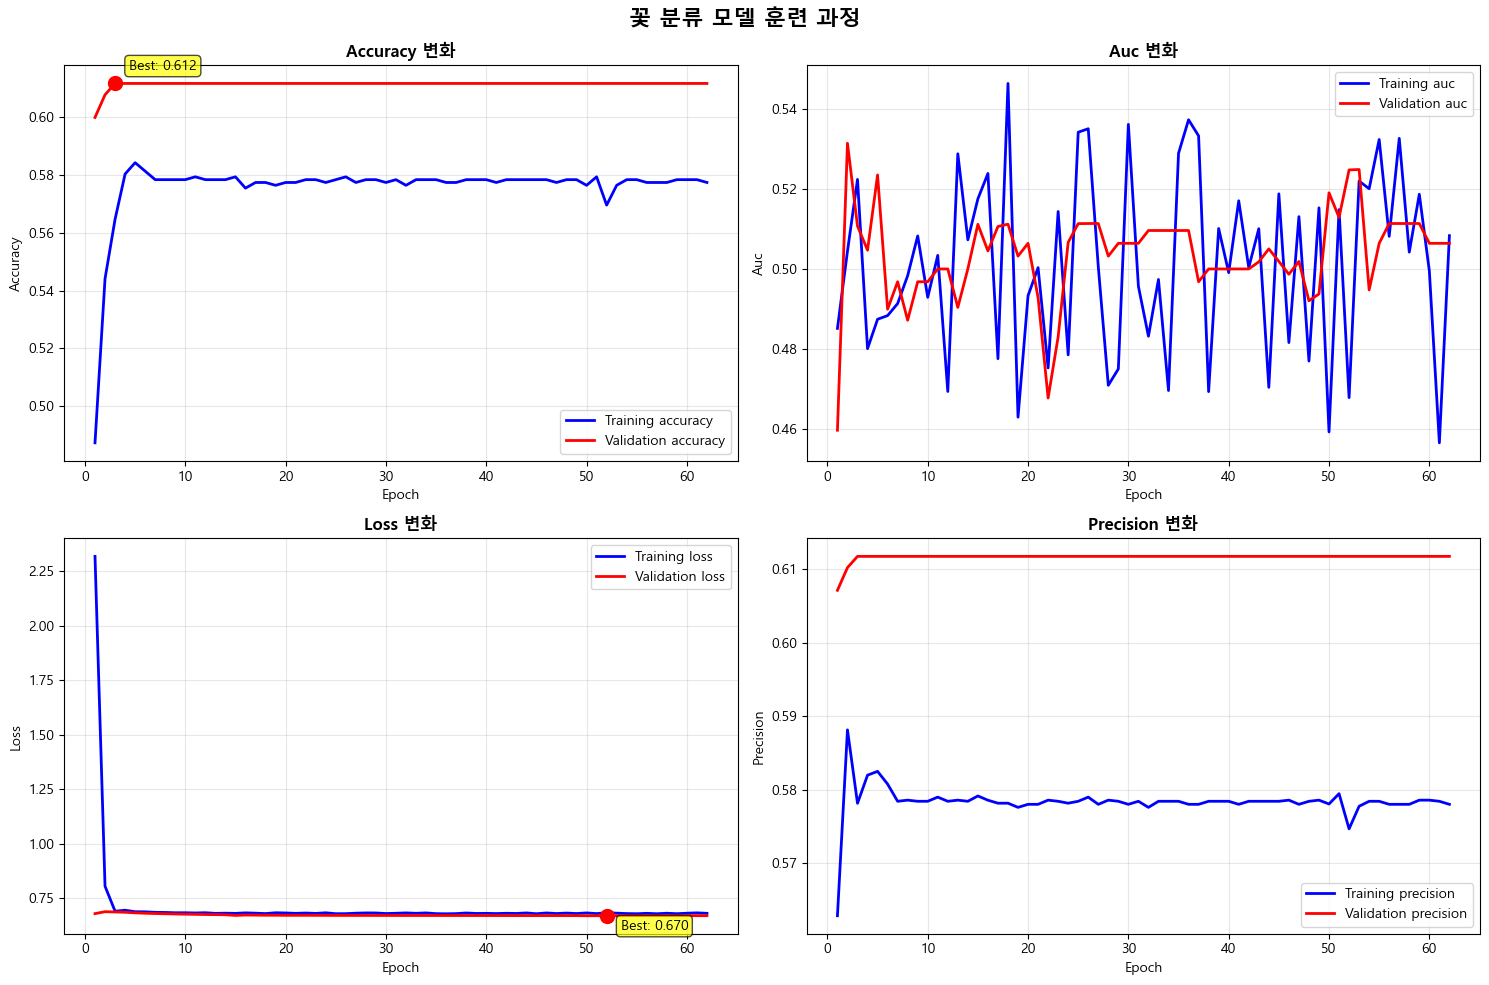


🎯 2. 혼동 행렬 및 분류 성능


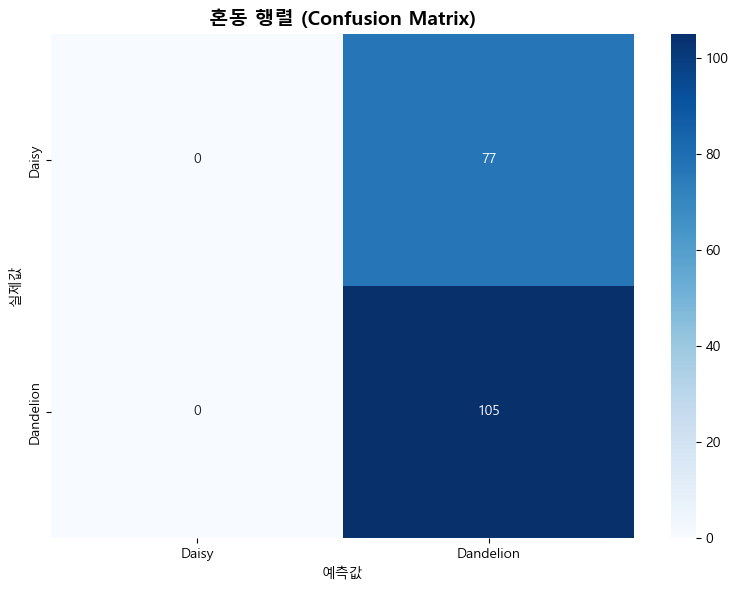

분류 성능 리포트:
              precision    recall  f1-score   support

       Daisy       0.00      0.00      0.00        77
   Dandelion       0.58      1.00      0.73       105

    accuracy                           0.58       182
   macro avg       0.29      0.50      0.37       182
weighted avg       0.33      0.58      0.42       182


📊 3. 예측 확률 분포


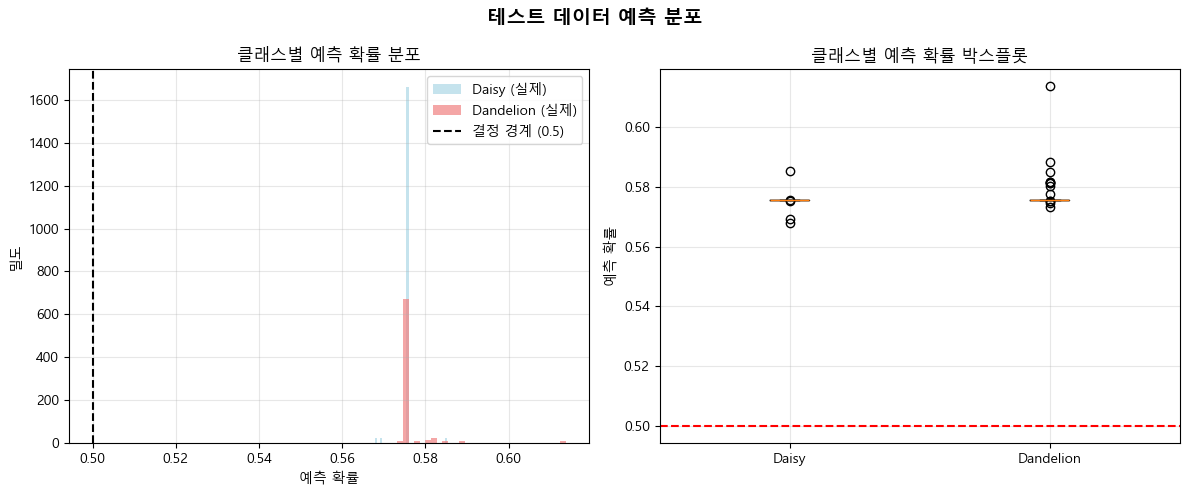


🔮 4. 샘플 예측 결과
📖 저장된 데이터 로드 중...
✅ 데이터 로드 완료!
📊 데이터 정보:
   - 훈련 데이터: (1275, 80, 80, 3)
   - 테스트 데이터: (182, 80, 80, 3)
   - 훈련 라벨 분포: [529 746]
   - 테스트 라벨 분포: [ 77 105]


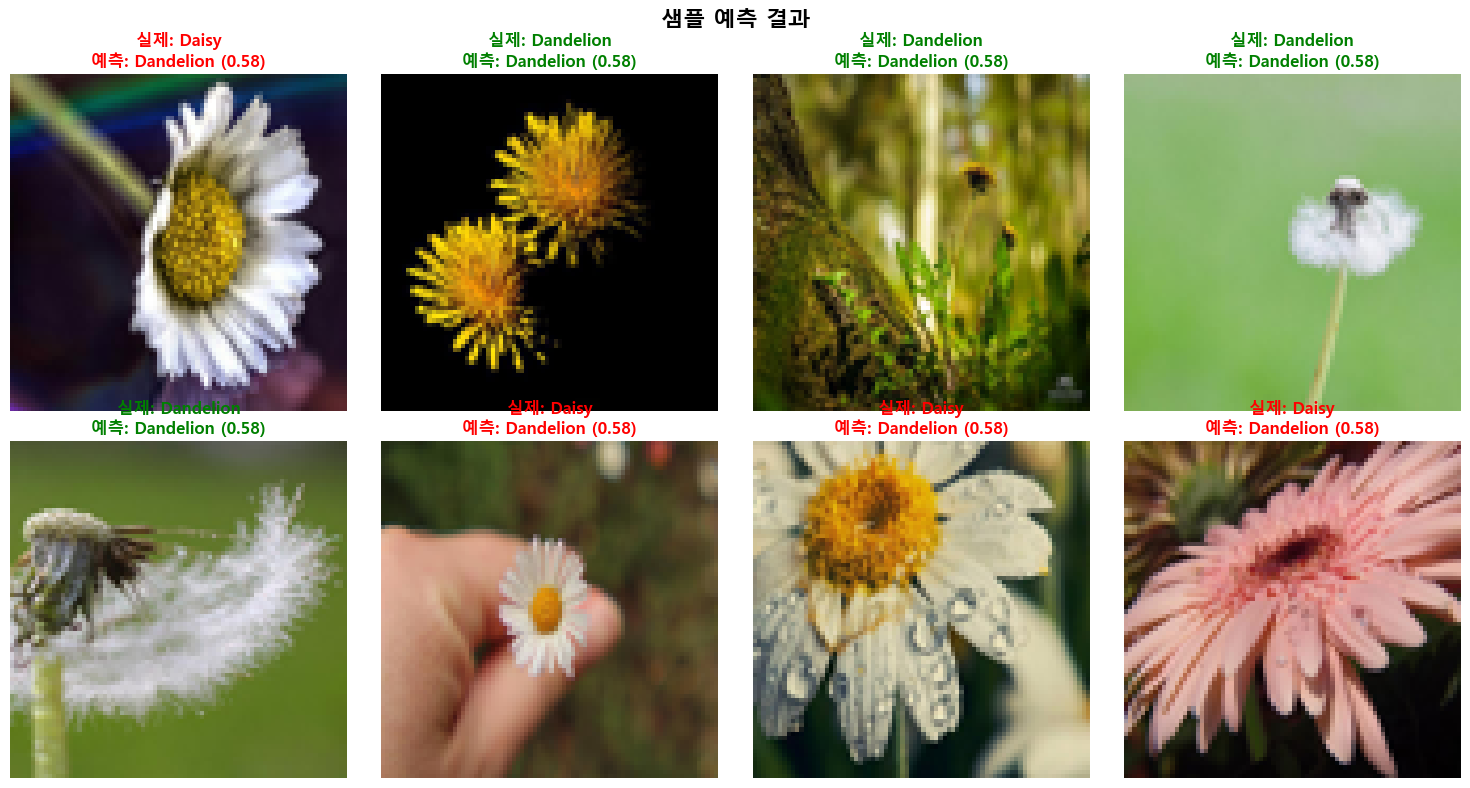


✅ 모든 시각화 완료!


In [54]:
# 📊 종합 결과 시각화
print("📈 1. 훈련 과정 시각화")
plot_training_history(training_history)

print("\n🎯 2. 혼동 행렬 및 분류 성능")
plot_confusion_matrix(y_test, evaluation_results['test_predictions'])

print("\n📊 3. 예측 확률 분포")
plot_prediction_distribution(y_test, evaluation_results['test_predictions'], "테스트 데이터 예측 분포")

print("\n🔮 4. 샘플 예측 결과")
# 원본 이미지 데이터가 필요하므로 다시 로드
X_train_raw, _, X_test_raw, _ = load_processed_data()
visualize_sample_predictions(trained_model, X_test_raw, y_test, n_samples=8)

print("\n✅ 모든 시각화 완료!")


### 7.5 💾 모델 저장 및 추가 활용

훈련된 모델을 저장하고 새로운 이미지에 대해 예측을 수행해보세요.


In [55]:
# 💾 모델 저장
model_save_path = Path("C:/Users/ryan9/문서/GitHub/SeSac-AI-Developer-Notes-2025/07_Deep_Learning/data/models/flower_classifier_final.h5")
model_save_path.parent.mkdir(parents=True, exist_ok=True)
trained_model.save(str(model_save_path))
print(f"✅ 모델이 저장되었습니다: {model_save_path}")

# 🔮 새로운 이미지 예측 예시 (경로를 실제 이미지 파일로 변경하세요)
# 예측하고 싶은 이미지의 경로를 지정하세요
# image_path = "path/to/your/flower/image.jpg"
# predicted_class, confidence = predict_single_image(trained_model, image_path)

print("\n🎉 축하합니다! 꽃 분류 모델 훈련이 완료되었습니다!")
print("\n📋 요약:")
print(f"   - 모델 아키텍처: Dense 신경망 ({CONFIG['HIDDEN_LAYERS']})")
print(f"   - 훈련 에포크: {len(training_history.history['loss'])}")

# 안전하게 메트릭에 접근
test_metrics = evaluation_results['test_metrics']
accuracy = get_metric_safely(test_metrics, 'accuracy')
precision = get_metric_safely(test_metrics, 'precision')
recall = get_metric_safely(test_metrics, 'recall')
auc = get_metric_safely(test_metrics, 'auc')

print(f"   - 최종 테스트 정확도: {accuracy:.4f}")
print(f"   - 정밀도(Precision): {precision:.4f}")
print(f"   - 재현율(Recall): {recall:.4f}")
print(f"   - AUC: {auc:.4f}")
print(f"   - 모델 저장 위치: {model_save_path}")

print("\n💡 다음 단계:")
print("   1. 하이퍼파라미터를 조정하여 성능 개선 시도")
print("   2. 더 복잡한 모델 (CNN) 구현")
print("   3. 데이터 증강 기법 적용")
print("   4. 더 많은 꽃 종류로 다중 분류 확장")


✅ 모델이 저장되었습니다: C:\Users\ryan9\문서\GitHub\SeSac-AI-Developer-Notes-2025\07_Deep_Learning\data\models\flower_classifier_final.h5

🎉 축하합니다! 꽃 분류 모델 훈련이 완료되었습니다!

📋 요약:
   - 모델 아키텍처: Dense 신경망 ([128, 64, 64, 32])
   - 훈련 에포크: 62
⚠️ 메트릭 'accuracy'을 찾을 수 없습니다. 사용 가능한 키: ['loss', 'compile_metrics']
⚠️ 메트릭 'precision'을 찾을 수 없습니다. 사용 가능한 키: ['loss', 'compile_metrics']
⚠️ 메트릭 'recall'을 찾을 수 없습니다. 사용 가능한 키: ['loss', 'compile_metrics']
⚠️ 메트릭 'auc'을 찾을 수 없습니다. 사용 가능한 키: ['loss', 'compile_metrics']
   - 최종 테스트 정확도: 0.0000
   - 정밀도(Precision): 0.0000
   - 재현율(Recall): 0.0000
   - AUC: 0.0000
   - 모델 저장 위치: C:\Users\ryan9\문서\GitHub\SeSac-AI-Developer-Notes-2025\07_Deep_Learning\data\models\flower_classifier_final.h5

💡 다음 단계:
   1. 하이퍼파라미터를 조정하여 성능 개선 시도
   2. 더 복잡한 모델 (CNN) 구현
   3. 데이터 증강 기법 적용
   4. 더 많은 꽃 종류로 다중 분류 확장


## 8. 📚 학습 정리 및 발전 방향

### 🎯 이번 실습에서 배운 내용

1. **이미지 데이터 전처리**
   - PIL을 사용한 이미지 읽기 및 크기 조정
   - RGB 이미지를 numpy 배열로 변환
   - 데이터 정규화 및 표준화

2. **신경망 모델 설계**
   - Dense(완전연결) 층을 사용한 이진 분류 모델
   - 드롭아웃을 통한 과적합 방지
   - Adam 옵티마이저와 Binary Crossentropy 손실함수

3. **모델 훈련 최적화**
   - EarlyStopping과 ReduceLROnPlateau 콜백 활용
   - 검증 데이터를 통한 모델 성능 모니터링
   - 배치 훈련과 에포크 관리

4. **성능 평가 및 시각화**
   - 혼동 행렬을 통한 분류 성능 분석
   - 훈련 과정 시각화
   - 예측 확률 분포 분석

### 🚀 성능 개선 방법

1. **모델 아키텍처 개선**
   - CNN(Convolutional Neural Network) 사용
   - 전이 학습(Transfer Learning) 적용
   - 앙상블 모델 구성

2. **데이터 증강**
   - 회전, 뒤집기, 확대/축소
   - 밝기, 대비 조정
   - 노이즈 추가

3. **하이퍼파라미터 튜닝**
   - 학습률 스케줄링
   - 배치 크기 최적화
   - 정규화 기법 적용

### 🔍 추가 학습 자료

- **CNN 기초**: 이미지 분류에 특화된 합성곱 신경망
- **전이 학습**: 사전 훈련된 모델 활용
- **데이터 증강**: tf.keras.preprocessing.image.ImageDataGenerator
- **모델 해석**: GradCAM, LIME 등을 통한 예측 근거 시각화
